# F. VOCAB-others

In [1]:
import pandas as pd
import numpy as np
import matplotlib
from glob import glob
import re
import nltk
import seaborn as sns
import plotly_express as px
sns.set()

import pandas as pd
import numpy as np
import re 
from numpy.linalg import norm
from scipy.spatial.distance import pdist, squareform
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer

In [2]:
data_home = 'C:/Users/user/Desktop/24Spring_ETA_Project/Dataset'
data_prefix = 'Star Wars- Episode '
output_dir = 'C:/Users/user/Desktop/24Spring_ETA_Project/Output'
path_prefix = 'starwars-combo'

OHCO = ['movie_id', 'chap_num', 'para_num', 'sent_num', 'token_num']
SENTS = OHCO[:4]
PARAS = OHCO[:3]
CHAPS = OHCO[:2]
MOVIES = OHCO[:1]

In [3]:
CORPUS_og = pd.read_csv(f"{output_dir}/{path_prefix}-CORPUS.csv")
# these terms indicates scene changes, but seems to have importance on tfidf, dfidf and such, so I'm erasing them for better interpretations
terms_to_remove = ['int', 'ext', 'interior', 'exterior']
filtered_CORPUS = CORPUS_og[~CORPUS_og['term_str'].isin(terms_to_remove)]
CORPUS = filtered_CORPUS.set_index(OHCO)
VOCAB = pd.read_csv(f"{output_dir}/{path_prefix}-VOCAB.csv").set_index('term_str')
TFIDF = pd.read_csv(f"{output_dir}/{path_prefix}-TFIDF.csv").set_index(CHAPS)

# VIDX

In [4]:
n_terms = 3000
vocab_filter = 'dfidf'
pos_list = "NN NNS VB VBD VBG VBN VBP VBZ JJ JJR JJS RB RBR RBS".split() # Open categories with no proper nouns

In [5]:
VIDX = VOCAB.loc[VOCAB.max_pos.isin(pos_list)]\
    .sort_values(vocab_filter, ascending=False)\
    .head(n_terms).index

In [6]:
M = TFIDF[VIDX].fillna(0).groupby('movie_id').mean() # MUST FILLNA

In [7]:
M

,i,are,is,up,t,be,have,day,down,cockpit,...,vine,cody,dack,greedo,na,log,fruit,drag,packing,blank
movie_id,,,,,,,,,,,,,,,,,,,,,
1,0.268705,0.168901,0.201666,0.098684,0.123427,0.126975,0.109289,0.242679,0.085810,0.066334,...,0.000000,0.000000,0.000000,0.021495,0.007608,0.000000,0.021115,0.000000,0.000000,0.000000
2,0.352885,0.170332,0.199681,0.114041,0.173575,0.111900,0.100387,0.239475,0.085975,0.048680,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.036762,0.000000,0.013863,0.005642
3,0.208534,0.113239,0.174095,0.104978,0.102879,0.095007,0.101610,0.227307,0.099917,0.020019,...,0.000000,0.049006,0.000000,0.000000,0.000000,0.000000,0.000000,0.015539,0.000000,0.000000
4,0.126037,0.074080,0.091958,0.070711,0.074830,0.067834,0.038341,0.006719,0.080890,0.360335,...,0.000000,0.000000,0.000000,0.011290,0.000000,0.002547,0.000000,0.000000,0.000000,0.000000
5,0.156910,0.071977,0.114551,0.087136,0.097601,0.067082,0.047441,0.024617,0.064698,0.212631,...,0.000000,0.000000,0.097761,0.000000,0.000000,0.001187,0.000000,0.000000,0.004502,0.000000
6,0.188611,0.089054,0.151944,0.091058,0.085410,0.069777,0.088526,0.000492,0.096498,0.037405,...,0.027608,0.000000,0.000000,0.000000,0.003381,0.017247,0.000000,0.007779,0.000000,0.024545


In [8]:
L0 = M.astype('bool').astype('int') # Binary (Pseudo L)
L1 = M.apply(lambda x: x / x.sum(), 1) # Manhattan (Probabilistic)
L2 = M.apply(lambda x: x / norm(x), 1) # Euclidean

In [9]:
PAIRS = M.T.corr().stack().to_frame('correl')
PAIRS.index.names = ['doc_a','doc_b']
PAIRS = PAIRS.query("doc_a > doc_b") # Remove identities and reverse duplicates

In [10]:
general_method = 'weighted' # single, complete, average, weighted 
euclidean_method = 'ward' # ward, centroid, median
combos  = [
    (L2, 'euclidean', 'euclidean', euclidean_method),
    (M,  'cosine', 'cosine', euclidean_method),
    (M,  'cityblock', 'cityblock', general_method),
    (L0, 'jaccard', 'jaccard', general_method),
    (L1, 'jensenshannon', 'js', general_method),
]

In [11]:
for X, metric, label, _ in combos:
    PAIRS[label] = pdist(X, metric)

In [12]:
PAIRS.style.background_gradient('GnBu', high=.5)

In [13]:
PAIRS.corr().style.background_gradient(cmap='GnBu', high=.5)

,correl,euclidean,cosine,cityblock,jaccard,js
correl,1.000000,-0.237859,-0.224543,-0.467716,-0.463566,-0.288480
euclidean,-0.237859,1.000000,0.999697,0.764481,0.708934,0.972300
cosine,-0.224543,0.999697,1.000000,0.757196,0.697509,0.970407
cityblock,-0.467716,0.764481,0.757196,1.000000,0.889737,0.842994
jaccard,-0.463566,0.708934,0.697509,0.889737,1.000000,0.791461
js,-0.288480,0.972300,0.970407,0.842994,0.791461,1.000000


## VIsualize

In [14]:
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt

In [15]:
LIB = pd.read_csv(f"{output_dir}/{path_prefix}-LIB.csv")
print(LIB['year'])
print(LIB['writer'])
print(LIB['movie_id'])

0    1999
1    2002
2    2005
3    1977
4    1980
5    1983
Name: year, dtype: int64
0              G.L
1              G.L
2              G.L
3              G.L
4    G.L, L.K, L.B
5          G.L,L.K
Name: writer, dtype: object
0    1
1    2
2    3
3    4
4    5
5    6
Name: movie_id, dtype: int64


In [16]:
def draw_hca(sims, linkage_method='complete', figsize=(5, 3)):
    global LIB
    
    tree = sch.linkage(sims, method=linkage_method)
    color_thresh = pd.DataFrame(tree)[2].mean()
    
    labels = LIB.label.values
    
    plt.figure()
    fig, axes = plt.subplots(figsize=figsize)
    dendrogram = sch.dendrogram(tree, 
                                labels=labels, 
                                orientation="left", 
                                count_sort=True,
                                distance_sort=True,
                                above_threshold_color='.75',
                                color_threshold=color_thresh,
                               )
    plt.tick_params(axis='both', which='major', labelsize=14)
    fig.suptitle(f"{label}–{linkage_method}", fontsize=20)
    
#     return fig

In [17]:
LIB['label'] = LIB.apply(lambda x: f"{x.movie_id}. {x.movie_title}({x.year}), by {x.writer}", 1)
LIB['label']

0                  1. The Phantom Menace(1999), by G.L
1                2. Attack of the Clones(2002), by G.L
2                 3. Revenge of the Sith(2005), by G.L
3                          4. A New Hope(1977), by G.L
4    5. The Empire Strikes Back(1980), by G.L, L.K,...
5              6. Return of the Jedi(1983), by G.L,L.K
Name: label, dtype: object

<Figure size 640x480 with 0 Axes>

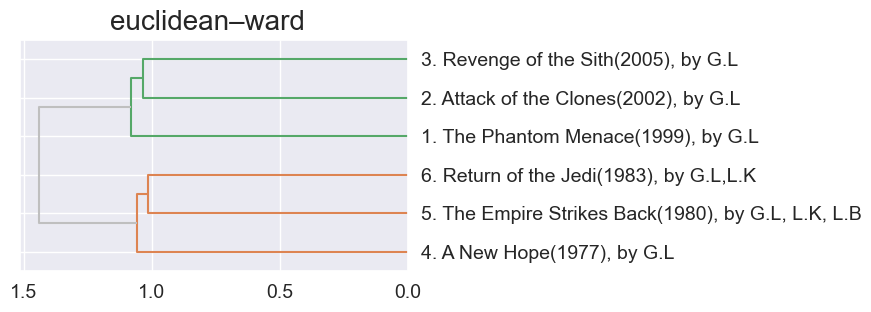

<Figure size 640x480 with 0 Axes>

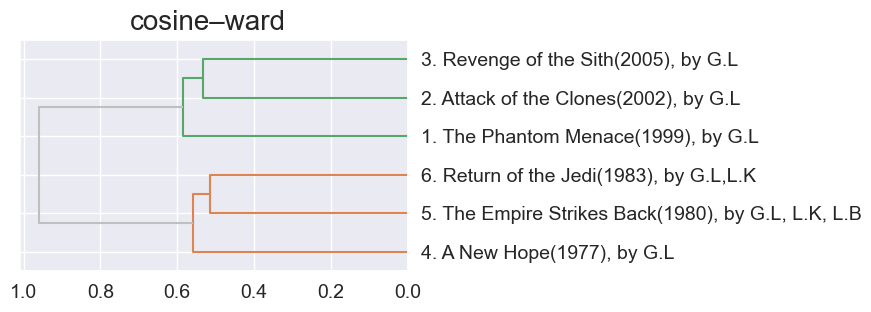

<Figure size 640x480 with 0 Axes>

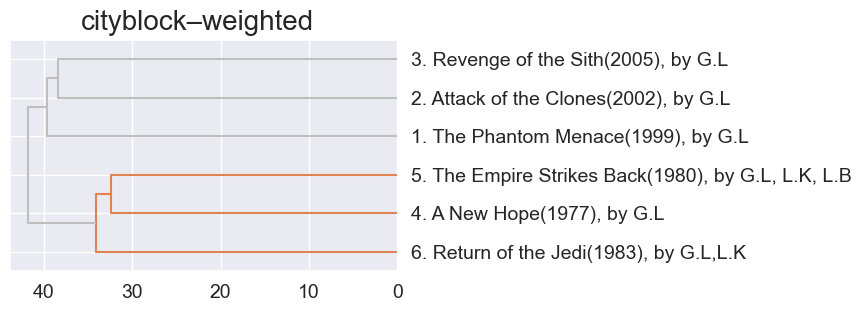

<Figure size 640x480 with 0 Axes>

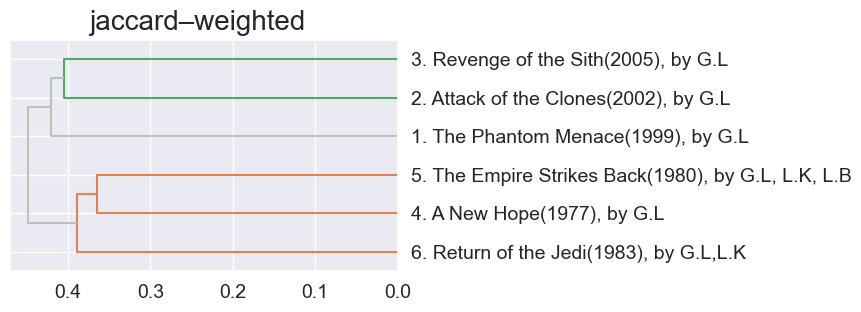

<Figure size 640x480 with 0 Axes>

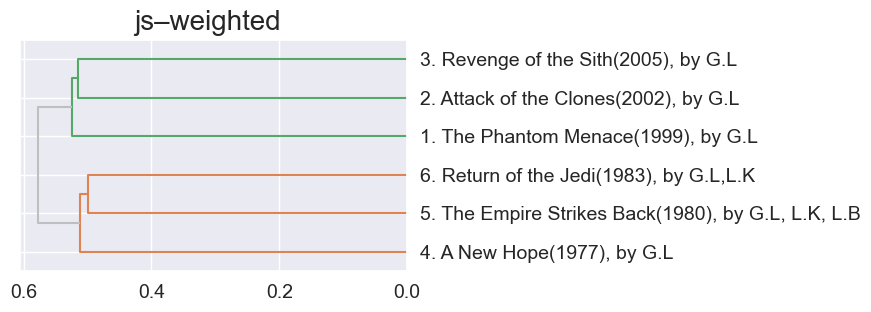

In [18]:
for X, metric, label, linkage in combos:
    draw_hca(PAIRS[label], linkage_method=linkage)

**Cosine-ward most distanced**

## BOW Reduced
tfidf mean, binary, tfidf_l1, tfidf_l2

In [19]:
BOW_REDUCED = M.stack().to_frame('tfidf_mean')
BOW_REDUCED['binary']   = L0.stack()
BOW_REDUCED['tfidf_l1'] = L1.stack()
BOW_REDUCED['tfidf_l2'] = L2.stack()
BOW_REDUCED = BOW_REDUCED.sort_index()

In [20]:
BOW_REDUCED

tfidf_mean  binary  tfidf_l1  tfidf_l2
movie_id                                                  
1        abilities    0.000000       0  0.000000  0.000000
         ability      0.000675       1  0.000018  0.000409
         able         0.008513       1  0.000231  0.005159
         aboard       0.008847       1  0.000240  0.005362
         abruptly     0.000000       0  0.000000  0.000000
...                        ...     ...       ...       ...
6        zaps         0.007591       1  0.000232  0.005769
         zev          0.000000       0  0.000000  0.000000
         zips         0.041522       1  0.001269  0.031554
         zoom         0.013331       1  0.000407  0.010130
         zooms        0.023658       1  0.000723  0.017978

[18000 rows x 4 columns]

# Save

In [21]:
BOW_REDUCED.to_csv(f"{output_dir}/other/{path_prefix}-BOW_REDUCED.csv", index=True)